# Plots
Andrew Walters

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import OrderedDict
%matplotlib inline

## Make All Plots

/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/matt/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


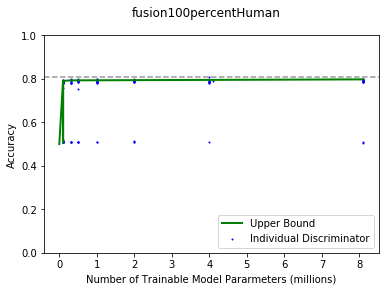

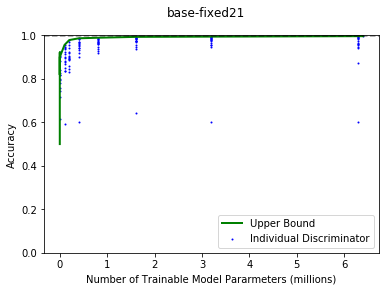

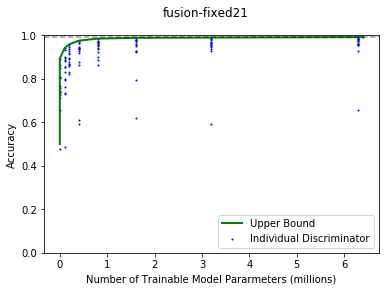

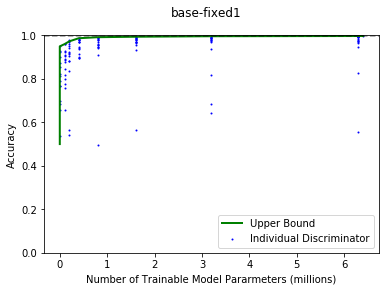

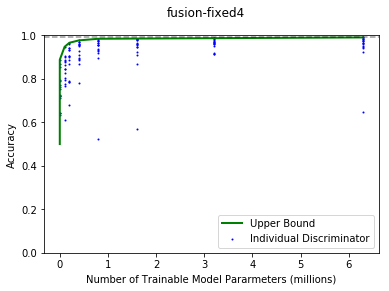

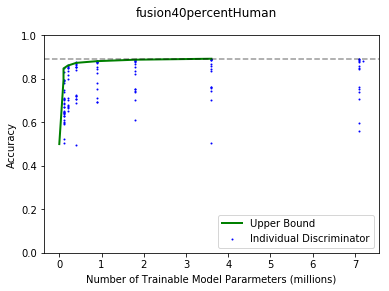

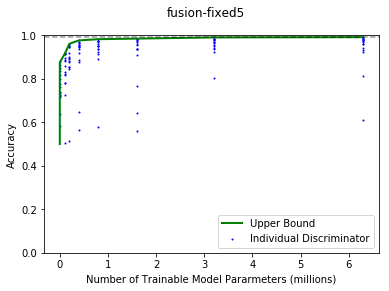

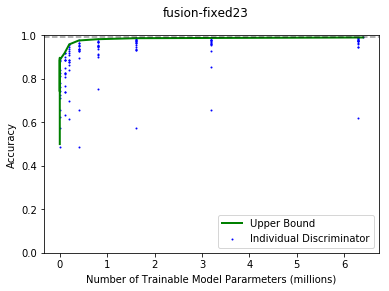

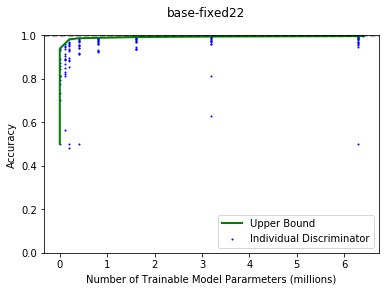

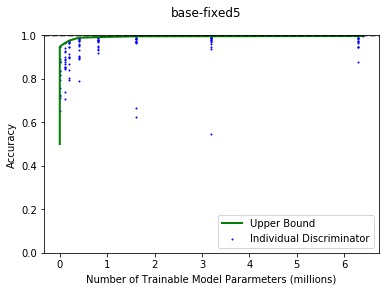

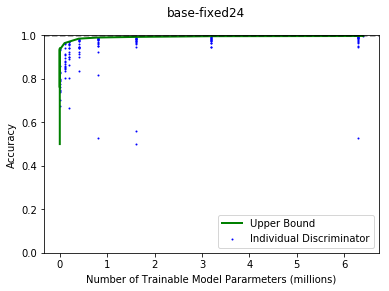

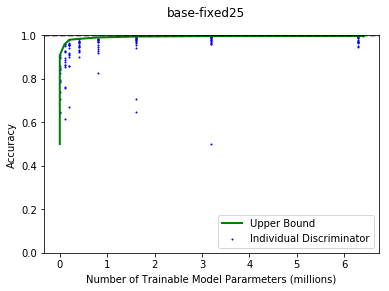

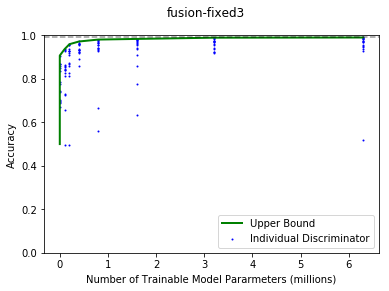

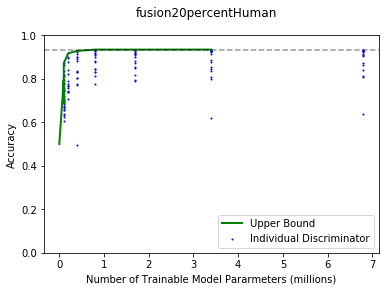

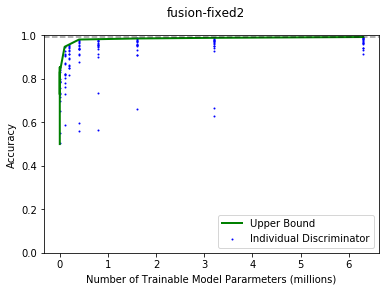

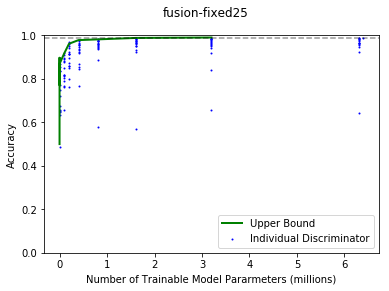

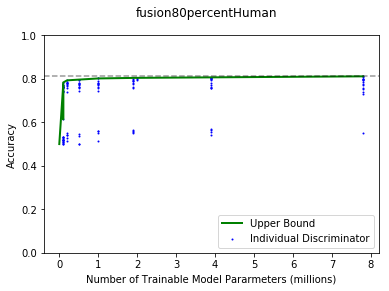

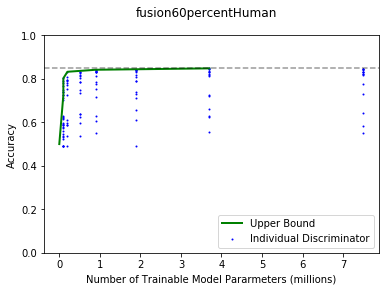

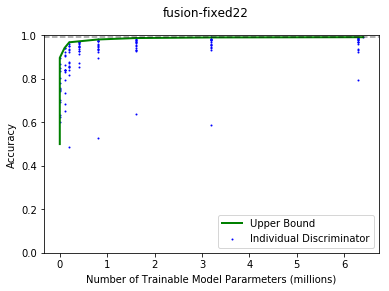

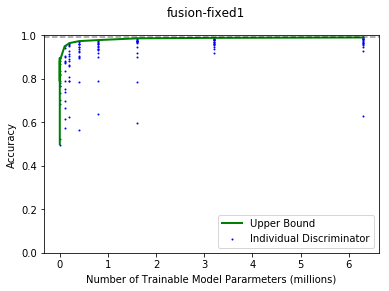

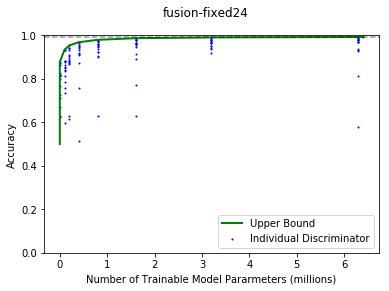

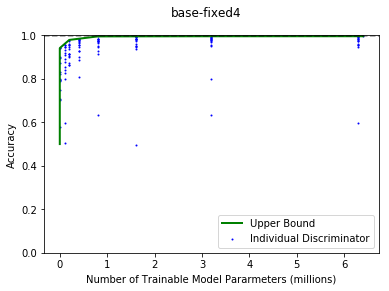

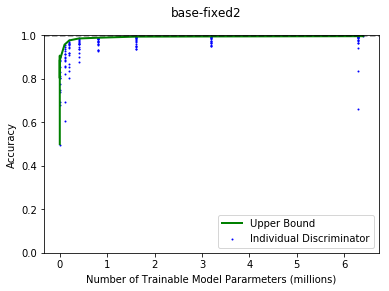

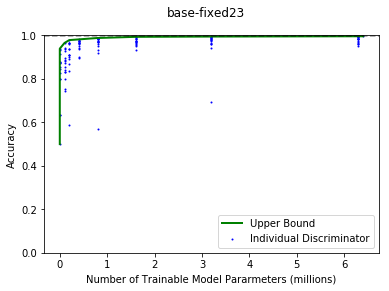

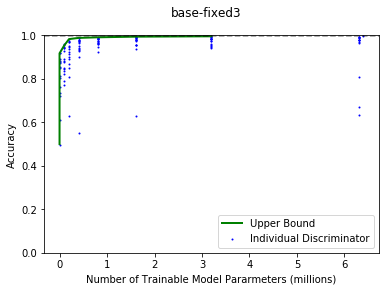

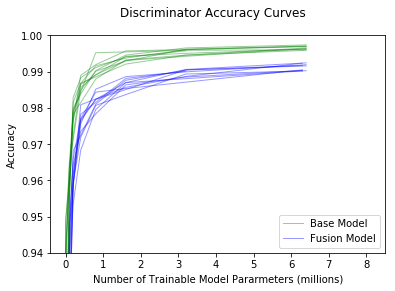

In [60]:
# find all the data and plot
params = {}
accuracy = {}
for path in os.listdir(os.getcwd()):
    if(os.path.isfile(path) and path[-3:]=="pkl"):
        model = path.split("_")[1]
        if(path[:8]=="accuracy"):
            accuracy[model] = pd.read_pickle(path)
        elif(path[:6]=="params"):
            params[model] = pd.read_pickle(path)
        else:
            pass
    if(os.path.isfile(path) and path[-3:]=="txt"):
        if(path[:5]=="stats"):
            pass
        else:
            pass

# make per-model plots
scale_params = {"units":"millions","conversion":(1/1000000)}
plot_one = True
fitted_lines = {}
for model in params.keys():
    p = params[model]
    a = accuracy[model]
    if(plot_one):
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        x,y = convert_data(p,a)
        scaled_x = [round(float(ii)*scale_params["conversion"],1) for ii in x]
        ax1.plot(scaled_x,y,"-",label="Upper Bound",LineWidth=2,c="g")
        scaled_params = [round(float(ii)*scale_params["conversion"],1) for ii in p]
        ax1.scatter(scaled_params,a,label="Individual Discriminator",s=1,marker="o",c="b")
        ax1.axhline(y=max(a), color='black', linestyle='--', alpha=.4)
        fig.suptitle(model)
        ax1.set_xlabel("Number of Trainable Model Pararmeters ({:s})".format(scale_params["units"]))
        ax1.set_ylabel("Accuracy")
        ax1.set_ylim(bottom=0.0,top=1.0)
        plt.legend(loc="lower right")
        fig.savefig(model)
        fitted_lines[model] = (scaled_x,y)
        #plot_one = False
        
# make results plot
line_colors = {"Fusion Model":"b","Base Model":"g"}
fig = plt.figure()
ax1 = fig.add_subplot(111)
fig.suptitle("Discriminator Accuracy Curves")
ax1.set_xlabel("Number of Trainable Model Pararmeters ({:s})".format(scale_params["units"]))
ax1.set_ylabel("Accuracy")
ax1.set_ylim(bottom=0.94,top=1.0)
for model in fitted_lines.keys():
    if(model.find("fusion-f")!=-1):
        mtype = "Fusion Model"
    elif(model.find("base-f")!=-1):
        mtype = "Base Model"
    else:
        pass
    (scaled_x,y) = fitted_lines[model]
    ax1.plot(scaled_x,y,"-",label=mtype,LineWidth=1,c=line_colors[mtype],alpha=0.4)

handles, labels = ax1.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower right")
fig.savefig("all_models")

## Matt's Helper Functions

In [48]:
def find_max_slope(params, accuracy, x=0, y=.5):

    max_slope = 0
    for i in range(len(params)):
        if ((accuracy[i] - y)/(params[i] - x)) > max_slope:
            max_slope = ((accuracy[i] - y)/(params[i] - x))
            index = i
    
    return params[index:], accuracy[index:], params[index], accuracy[index]
    
def convert_data(params, accuracy):
    
    params_list = [0]
    accuracy_list = [.5]

    params, accuracy, next_params, next_accuracy = find_max_slope(params, accuracy)

    params_list.append(next_params)
    accuracy_list.append(next_accuracy)

    while True:
        try:
            params, accuracy, next_params, next_accuracy = find_max_slope(params, accuracy, next_params, next_accuracy)

            params_list.append(next_params)
            accuracy_list.append(next_accuracy)

        except: 
            break
    
    return (params_list, accuracy_list)

def calc_metric(data):
    
    params = data[0]
    acc = data[1]
    
    area = 0
    for i in range(len(params)-1):
        delta_area = acc[i]*(params[i+1]-params[i])
        area += delta_area
        
    for i in range(len(params)-1):
        delta_area = (params[i+1]-params[i])*(acc[i+1]-acc[i])/2
        area += delta_area

    return (max(acc)*max(params) - area)